# Example of GazeScoring processing


## Example of processing video files

The cell below is a demosntration of the how raw videos are processed using the GazeScorer pipeline. Intially the videos are pre-processed to a useable format and are then split into the individual frames for anaylis. The frames are then processed to mark out the facial features generating a DataFrame, refered to as the *etdset*. The next stages process the etdset to identify the iris location and subsequently estimate the gaze location appending these columns to the Dataframe. A LKV processes is applied to remove any blinks to finalise the automated gaze scoring. In addition, manual scoring data and stimuli location timestamps are added to the etdset DataFrame. Finally the dataframe is reduced to the desired columns. In the subsequent cell a number of basic Cohen kappa metrics are calcualted an plotted for the example videos. 

For this example there are three demonstration videos that are available to process from researchers who have given their consent to be used for this example. Analysis of the fully annonymised data sets for both the child and adult samples can be found in the folder *R_analysis*. 



In [1]:
from datetime import datetime
import pandas as pd
import GazeScorer as gs
import os
print(os.getcwd())

# Sets  up the path and information for the input videos and locations where the processed videos should be saved
input_path = 'input/example_video/'
file_list = ['example_1_video.webm', 'example_2_video.webm', 'example_3_video.webm']
participant_ids = ["EX_001", "EX_002", "EX_003"]
processed_path= 'input/example_video/processed/'

# Sets the location and file names for the corresponding manual scoring files
scoring_path = 'input/example_scoring/'
scoring_list = ['example_1_scoring.csv', 'example_2_scoring.csv', 'example_3_scoring.csv']

# The video length varible corresponds to the length of the experimental trial. 
# The minus value instructs the preprocessing function to trim the video from the end of the file
video_length = -14.41

# The fdir varibale can be used to assign a path to save the frames as images if required.
fdir = None

# Sets up an empty DataFrame for the aggregate etdset
output_etdset = pd.DataFrame({'PID':[]})

# Loops through all of the demonstration files
for i, file in enumerate(file_list):
    
    # Establishes paths and reads in required csv files. 
    input_file = f'{input_path}{file}'
    processed_file = f'{processed_path}{file}'
    scoring_file = f'{scoring_path}{scoring_list[i]}'
    scoring = pd.read_csv(scoring_file)
    tstamp = pd.read_csv('input//example_scoring//twopoints_timestamp.csv')

    # Established participanf ID
    PID = participant_ids[i]

    # Preprocesses the video file. Returs the path the processed file and a dictionary of the videos meta data. 
    # The alt_processing argument is used to use an older method of extractig files that corresponds with the manually scored data
    vid_out_file, meta =  gs.video_utils.preprocess_video(input_file, video_length=video_length, processed_fname=processed_file, require_meta=True, alt_processing=True, overwrite_video=True)

    # Extracts the frames and saves them into an array. Returns the array and a list of timestamps for each frame.  
    frames, tstamps = gs.video_utils.extract_video_frames(vid_out_file, meta=meta, frame_dir=fdir, alt_processing=True)


    # process frames to get the face coordiates and establish the etdset DataFrame
    etdset = gs.image_utils.process_frames(frames, multiple_id=False)
    

    # add timestamps to the data set
    etdset["frame_timestamp"] = tstamps

    # Process the landmarks to find the iris shape within the eye and estimate gaze orientation
    etdset, aratios = gs.image_utils.process_lmarks(
        etdset)
    
    # prepares data by reassigning column names for readability and selecting the neccesary columns
    etdset = gs.post_utils.prepare_output(etdset)
    
    #Applies the LKV processing to the data set to remove blinks and other lost data.
    # Include scoring indicates if lkv should also be applied for scoring values
    etdset = gs.post_utils.lkv_process(etdset)
    
    # Drops the first frames that were included in the scoring
    fcorrect = len(etdset) - len(scoring)
    etdset = etdset.drop(etdset.head(fcorrect).index).reset_index()

    # Adds the manually scored data to the etdset dataframe
    etdset = gs.post_utils.add_scoring(etdset, left_eye=scoring['leye'], right_eye=scoring['reye'], overall_scoring=scoring['overall'])

    # Calculates and adds the stimuli locatio timestamps
    etdset = gs.post_utils.add_timestamp(etdset, h_event_start=tstamp['event_start'], h_location_key=tstamp['h_score'], h_movement_key=tstamp['Phase'])

    # Adds the participants id and the adult/child group idetnifier
    # etdset.insert(0,column='PID',value= PID)
    etdset['PID'] = PID

    # Add the etdset to the overall output dataframe
    output_etdset = pd.concat([output_etdset, etdset])

now = datetime.now()
dt_string = now.strftime("%d-%m_%H%M")
output_etdset.to_csv(f'output/example_datasets/example_etdset_{dt_string}.csv')


/Users/alexwork/Desktop/BRM_example_code_share/video_processing
duration = 22.565
video_length = 14.41
start time = 8.155000000000001
Cutting video betweeen 8.155000000000001 and 22.565
Processsing 431 frames
error limit = 129.29999999999998
duration = 21.71
video_length = 14.41
start time = 7.300000000000001
Cutting video betweeen 7.300000000000001 and 21.71
Processsing 434 frames
error limit = 130.2
duration = 24.565
video_length = 14.41
start time = 10.155000000000001
Cutting video betweeen 10.155000000000001 and 24.565
Processsing 433 frames
error limit = 129.9


# Analysis of full data set

## Cohens Kappa analysis - example participants

### CK data - Static stimuli phase

In [8]:
# Selects data where the target stimuli was static 
static_output_etdset = output_etdset[output_etdset['h_movement'] != 'moving']

# Creates a list of particiapnts in the dataframe
PID_list = output_etdset['PID'].unique()

# Creates an empty dataframe to save cohens kappa scores
static_adult_ckap = pd.DataFrame({"PID":[]})

# loop through each participant 
for PID in PID_list:
     
    # Selects data for the current participant
    etdset = static_output_etdset[static_output_etdset['PID'] == PID]

    # Gets the K score and 95% CI intervals for each eye
    temp_ckap = gs.post_utils.ckap(etdset)
    temp_ckap['PID'] = PID

    # Appends current participant data 
    static_adult_ckap = pd.concat([static_adult_ckap, temp_ckap])

# Gets at total CK score for the full datset and appends
_, static_adult_matrix = gs.post_utils.ckap(static_output_etdset, matrix=True)

print(static_adult_ckap.to_string())

      PID  k_overall  CI_low_overall  CI_upp_overall  k_left  CI_low_left  CI_upp_left   k_right  CI_low_right  CI_upp_right
0  EX_001   0.989779        0.969779        1.009779     1.0          1.0          1.0  0.989779      0.969779      1.009779
0  EX_002   1.000000        1.000000        1.000000     1.0          1.0          1.0  1.000000      1.000000      1.000000
0  EX_003   1.000000        1.000000        1.000000     1.0          1.0          1.0  1.000000      1.000000      1.000000


/Users/alexwork/opt/miniconda3/envs/BRM_GS/lib/python3.10/site-packages/statsmodels/stats/inter_rater.py:499: RuntimeWarning: invalid value encountered in sqrt


#### Confusion matrix of overall data

In [9]:
print(static_adult_matrix.to_string())

          a_right  a_centre  a_left
s_right     531.0       0.0     0.0
s_centre      1.0      90.0     0.0
s_left        0.0       0.0    91.0


#### Plot of Cohen's K scores

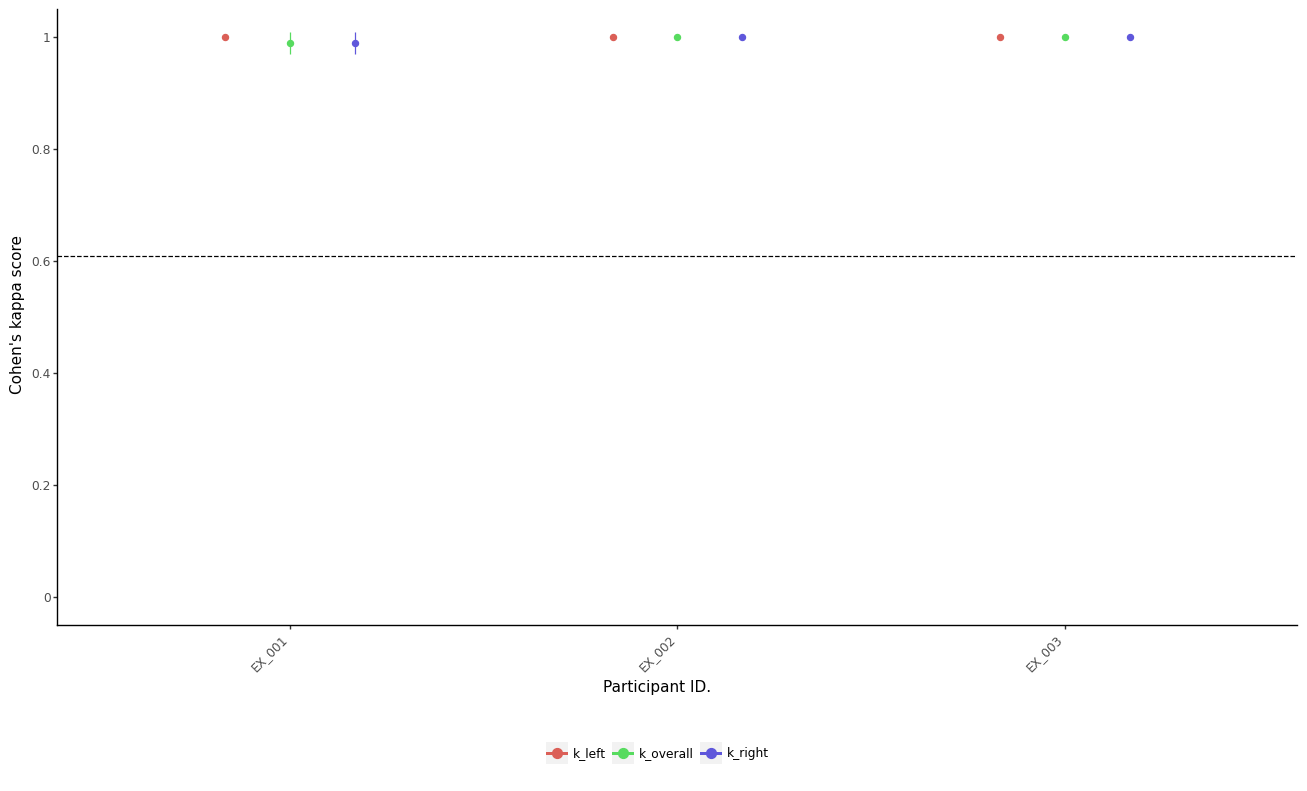

In [4]:

gs.plot_utils.plot_ckap(static_adult_ckap)

### CK data - Dynamic stimuli phase

In [5]:
# Selects data where the target stimuli was dynamic 
dynamic_output_etdset = output_etdset[output_etdset['h_movement'] == 'moving']

# Creates a list of particiapnts in the dataframe
PID_list = output_etdset['PID'].unique()

# Creates an empty dataframe to save cohens kappa scores
dynamic_adult_ckap = pd.DataFrame({"PID":[]})

subset = {'0.5': [0,0.5], '1': [0.5, 1], '0.75': [0.75, 1]}

# loop through each participant 
for PID in PID_list:
     
    # Selects data for the current participant
    etdset = dynamic_output_etdset[dynamic_output_etdset['PID'] == PID]

    sub_dynamic_output= pd.DataFrame()
    # Gets the K score and 95% CI intervals for each eye
    temp_ckap = gs.post_utils.ckap(etdset)
    temp_ckap['PID'] = PID

    # Appends current participant data 
    dynamic_adult_ckap = pd.concat([dynamic_adult_ckap, temp_ckap])

# Gets at total CK score for the full datset and appends
_, dynamic_adult_matrix = gs.post_utils.ckap(dynamic_output_etdset, matrix=True)


print(dynamic_adult_ckap.to_string())

      PID  k_overall  CI_low_overall  CI_upp_overall    k_left  CI_low_left  CI_upp_left   k_right  CI_low_right  CI_upp_right
0  EX_001   0.386142        0.281450        0.490834  0.406056     0.298246     0.513867  0.412275      0.317353      0.507196
0  EX_002   0.433868        0.325470        0.542267  0.558277     0.455904     0.660650  0.346573      0.236652      0.456495
0  EX_003   0.736771        0.656754        0.816787  0.678769     0.591007     0.766531  0.794809      0.721013      0.868606


#### Confusion data

In [6]:
print(dynamic_adult_matrix.to_string())

          a_right  a_centre  a_left
s_right     143.0      55.0    68.0
s_centre     38.0     117.0     0.0
s_left       25.0       0.0   136.0


#### Plot of CK data

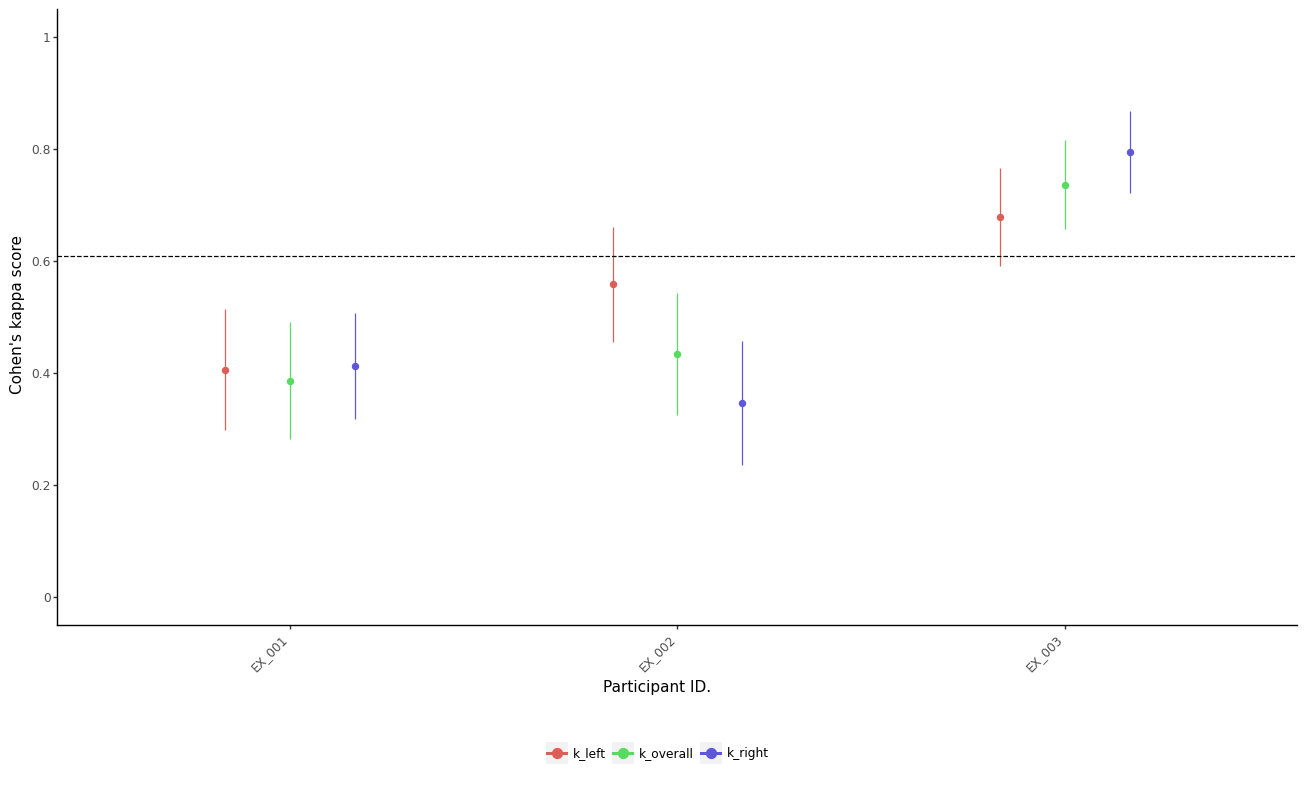

In [7]:

gs.plot_utils.plot_ckap(dynamic_adult_ckap)